# SetUp

## import

In [3]:
# Import packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import xgboost as xgb

import tensorflow as tf
import pmdarima as pm
import lightgbm as lgb
import holidays
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , make_scorer, mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras import regularizers, Sequential, layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.model_selection import GridSearchCV

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import learning_curve


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU, Normalization, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


2024-11-09 16:32:14.293631: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)

# Data Loading

## Read csv

In [5]:
df = pd.read_csv('./raw_data/powerconsumption.csv')
df.head()

,Datetime,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


# Data Cleaning

## Handle Missings

It is clear that we have outliers in the Diffuse Flows and General Diffuse Flows.

In [6]:
def detailed_check_df(dataframe, head=5):
    print("Shape:")
    print(dataframe.shape)

    print("Info:")
    # what is memory_usage attribute?
    # If we have large strings, we can convert them to other types, such as categories, to save space.
    print(dataframe.info(memory_usage='deep'))

    print("Types:")
    print(dataframe.dtypes)

    print("Missing Values:")
    missing_values = dataframe.isnull().sum()
    print(missing_values[missing_values > 0])

    print("Unique Values:")
    for column in dataframe.columns:
        print(f"{column} has {dataframe[column].nunique()} unique values")

detailed_check_df(df)

Shape:
(52416, 9)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.8 MB
None
Types:
Datetime                   object
Temperature               float64
Humidity                  float64
WindSpeed                 float64
GeneralDiffuseFlows       float64
DiffuseFlows              float64
PowerConsumption_Z

In [7]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

The outliers are clearly visible in both GeneralDiffuseFlows and DiffuseFlows

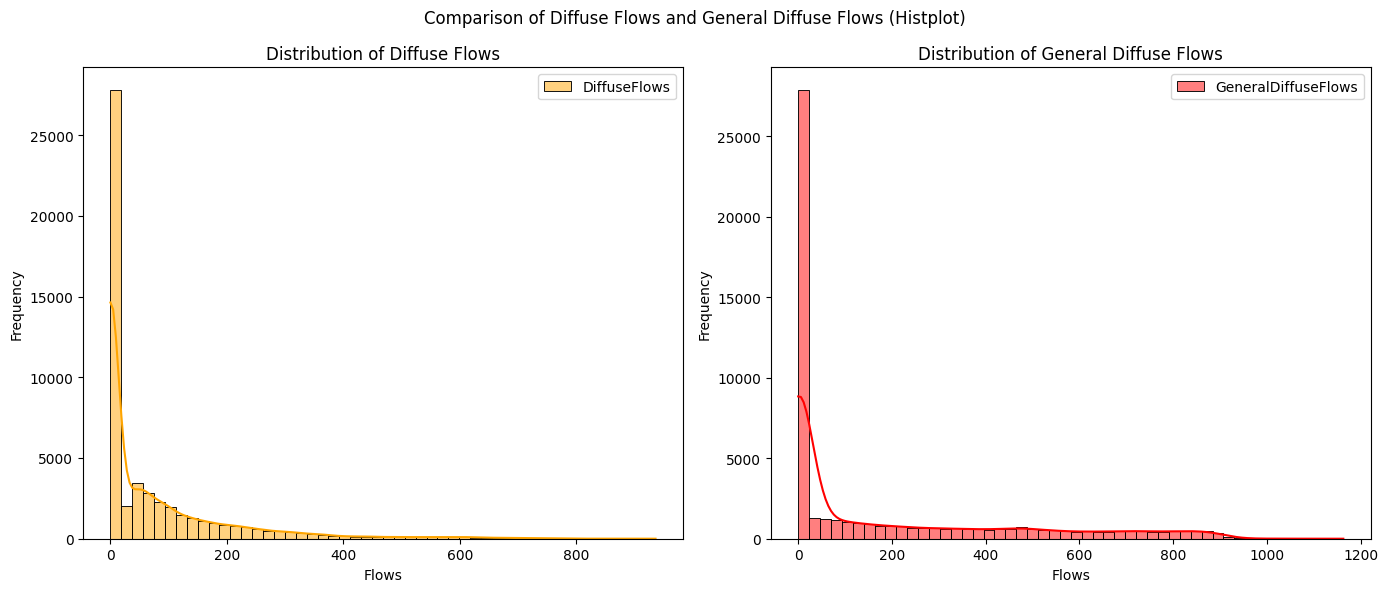

In [8]:
# plotting the histograms for DiffuseFlows and GeneralDiffuseFlows using histplot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Diffuse Flows
sns.histplot(df['DiffuseFlows'], kde=True, label='DiffuseFlows', color='orange', bins=50, ax=ax[0])
ax[0].set_title('Distribution of Diffuse Flows')
ax[0].set_xlabel('Flows')
ax[0].set_ylabel('Frequency')
ax[0].legend()

# Plot for General Diffuse Flows
sns.histplot(df['GeneralDiffuseFlows'], kde=True, label='GeneralDiffuseFlows', color='red', bins=50, ax=ax[1])
ax[1].set_title('Distribution of General Diffuse Flows')
ax[1].set_xlabel('Flows')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.suptitle('Comparison of Diffuse Flows and General Diffuse Flows (Histplot)')
plt.tight_layout()
plt.show()

Remove unnecessary columns

In [9]:
df = df.drop(columns = [ 'DiffuseFlows', 'GeneralDiffuseFlows'])

In [10]:
df.dtypes

Datetime                   object
Temperature               float64
Humidity                  float64
WindSpeed                 float64
PowerConsumption_Zone1    float64
PowerConsumption_Zone2    float64
PowerConsumption_Zone3    float64
dtype: object

# Data Preparing

## DateTime index

In [11]:
df['Datetime'] = pd.to_datetime(df['Datetime'],format='%m/%d/%Y %H:%M')
df.set_index('Datetime', inplace=True)

df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964


In [12]:
# Create new columns using the Datetime index
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Hour'] = df.index.hour
df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour
Datetime,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0


## Add IsHoliday column

### Insert the 2017 Moroccan Holiday Dataset


Holidays in Morocco for the year 2017 will be added using a holidays library. The goal is to introduce a new feature to the dataset, allowing us to measure electricity consumption on holidays versus non-holidays.

In [13]:
df.index = pd.to_datetime(df.index)
df['Date'] = df.index.date

# Initialize the Morocco holidays for the year 2017
morocco_holidays = holidays.Morocco(years=[2017])

# Add the 'IsHoliday' column
df['IsHoliday'] = df['Date'].apply(lambda x: 1 if x in morocco_holidays else 0)
df = df.drop(columns = ['Date'])

df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,IsHoliday
Datetime,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0,1
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0,1
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0,1
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0,1
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0,1


### Morocco holidays for 2017

#### To ensure accuracy, this is list all holidays for Morocco in 2017 generated by the holidays library.

In [14]:
# Print all holidays in Morocco for 2017
for date, name in sorted(morocco_holidays.items()):
    print(date, name)

2017-01-01 رأس السنة الميلادية
2017-01-11 ذكرى تقديم وثيقة الاستقلال
2017-05-01 عيد العمال
2017-06-25 (تقدير) عيد الفطر
2017-06-26 (تقدير) عيد الفطر
2017-07-30 عيد العرش
2017-08-14 ذكرى استرجاع إقليم وادي الذهب
2017-08-20 ذكرى ثورة الملك و الشعب
2017-08-21 عيد الشباب
2017-09-01 (تقدير) عيد الأضحى
2017-09-02 (تقدير) عيد الأضحى
2017-09-21 (تقدير) رأس السنة الهجرية
2017-11-06 ذكرى المسيرة الخضراء
2017-11-18 عيد الإستقلال
2017-11-30 (تقدير) عيد المولد النبوي
2017-12-01 (تقدير) عيد المولد النبوي


In [15]:
df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,IsHoliday
Datetime,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0,1
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0,1
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0,1
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0,1
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0,1


## Time of Day and Weekend Classification

Time-of-day categories will be added based on the hour, and new columns will be added to determine the day of the week and whether it's a weekend or not.

In [16]:
# Define time of day categories
def categorize_time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Categorize the time of day using the 'Hour' column
df['TimeOfDay'] = df['Hour'].apply(categorize_time_of_day)

# Add day of the week and check if it is a weekend
df['Weekday'] = df.index.weekday  # Access weekday from index
# Add a column to indicate if it's a weekend
df['IsWeekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)

df = df.drop(columns = ['Weekday'])

## Season Classification

Months will be classified into seasons, a "Season" column will be added, and specific columns will be converted to numeric types.

In [17]:
# Define the seasons
def categorize_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Season'] = df['Month'].apply(categorize_season)

# Let's set the data types to numeric
df['Year'] = df['Year'].astype(int)
df['IsWeekend'] = df['IsWeekend'].astype(int)
df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,IsHoliday,TimeOfDay,IsWeekend,Season
Datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0,1,Night,1,Winter
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0,1,Night,1,Winter
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0,1,Night,1,Winter
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0,1,Night,1,Winter
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0,1,Night,1,Winter


## Zones

### dealing with one city better than multi-zones

In [18]:
df['TotalPowerConsumption'] = df['PowerConsumption_Zone1'] + df['PowerConsumption_Zone2'] + df['PowerConsumption_Zone3']
df.head()

,Temperature,Humidity,WindSpeed,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,Year,Month,Day,Hour,IsHoliday,TimeOfDay,IsWeekend,Season,TotalPowerConsumption
Datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,34055.69620,16128.87538,20240.96386,2017,1,1,0,1,Night,1,Winter,70425.53544
2017-01-01 00:10:00,6.414,74.5,0.083,29814.68354,19375.07599,20131.08434,2017,1,1,0,1,Night,1,Winter,69320.84387
2017-01-01 00:20:00,6.313,74.5,0.080,29128.10127,19006.68693,19668.43373,2017,1,1,0,1,Night,1,Winter,67803.22193
2017-01-01 00:30:00,6.121,75.0,0.083,28228.86076,18361.09422,18899.27711,2017,1,1,0,1,Night,1,Winter,65489.23209
2017-01-01 00:40:00,5.921,75.7,0.081,27335.69620,17872.34043,18442.40964,2017,1,1,0,1,Night,1,Winter,63650.44627


### Drop all zones

In [19]:
df.drop(columns=['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3'], inplace=True)
df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,TimeOfDay,IsWeekend,Season,TotalPowerConsumption
Datetime,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,Night,1,Winter,70425.53544
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,Night,1,Winter,69320.84387
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,Night,1,Winter,67803.22193
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,Night,1,Winter,65489.23209
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,Night,1,Winter,63650.44627


### Average income per capita in Morocco by year

In [20]:
AverageIncome_2017= 3288.50
AverageIncome_2024= 3489
# https://ycharts.com/indicators/morocco_gdp_per_capita_usd

df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,TimeOfDay,IsWeekend,Season,TotalPowerConsumption
Datetime,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,Night,1,Winter,70425.53544
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,Night,1,Winter,69320.84387
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,Night,1,Winter,67803.22193
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,Night,1,Winter,65489.23209
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,Night,1,Winter,63650.44627


##  ENCODING -OneHotIncoder


In [21]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[['Season', 'TimeOfDay']])
df[ohe.get_feature_names_out(['Season', 'TimeOfDay'])] = ohe.transform(df[['Season', 'TimeOfDay']])
df = df.drop(columns = ['Season', 'TimeOfDay'])

df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,70425.53544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,69320.84387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,67803.22193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,65489.23209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,63650.44627,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


# Exploratory Data Analysis 📊

## Correlation Analysis

In [22]:
# Calculate the correlation coefficient between Total consumption and each factor.
correlation_temp = df['TotalPowerConsumption'].corr(df['Temperature'])
correlation_humidity = df['TotalPowerConsumption'].corr(df['Humidity'])
correlation_wind_speed = df['TotalPowerConsumption'].corr(df['WindSpeed'])
correlation_isHoliday = df['TotalPowerConsumption'].corr(df['IsHoliday'])

# print the results
print("Correlation with Temperature:", correlation_temp)
print("Correlation with Humidity:", correlation_humidity)
print("Correlation with Wind Speed:", correlation_wind_speed)
print("Correlation with Is Holday:", correlation_isHoliday)

Correlation with Temperature: 0.4882384320045328
Correlation with Humidity: -0.29905902107542187
Correlation with Wind Speed: 0.2217061054966012
Correlation with Is Holday: -0.00394457293994302


In [23]:
df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,70425.53544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,69320.84387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,67803.22193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,65489.23209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,63650.44627,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Visualize relationships

In [24]:
df.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'Year', 'Month', 'Day', 'Hour',
       'IsHoliday', 'IsWeekend', 'TotalPowerConsumption', 'Season_Autumn',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'TimeOfDay_Afternoon', 'TimeOfDay_Evening', 'TimeOfDay_Morning',
       'TimeOfDay_Night'],
      dtype='object')

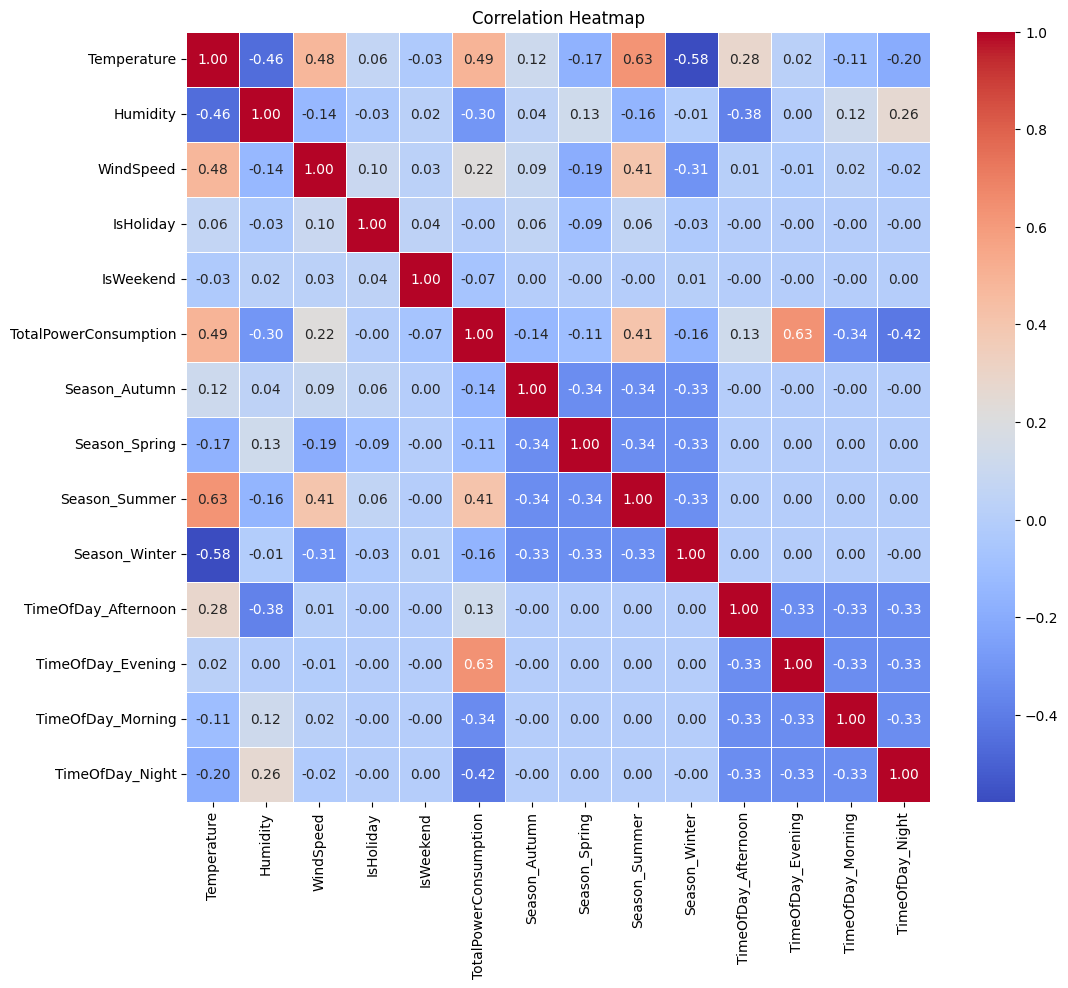

In [25]:
columns_to_include = ['Temperature', 'Humidity', 'WindSpeed',
       'Month', 'Day', 'Hour', 'IsHoliday', 'Weekday',
       'IsWeekend', 'TotalPowerConsumption', 'Season_Autumn', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'TimeOfDay_Afternoon', 'TimeOfDay_Evening',
       'TimeOfDay_Morning', 'TimeOfDay_Night']

# Check if columns exist in DataFrame
existing_columns = [col for col in columns_to_include if col in df.columns]

# Calculate correlation matrix for existing columns only
correlation_matrix = df[existing_columns].select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Converts the date index to weekly periods, groups data by week to calculate the mean energy consumption, and creates an interactive box plot using Plotly to visualize weekly energy consumption. It customizes the x-axis for better readability and displays all outliers.

# Resample

## Daily Resample

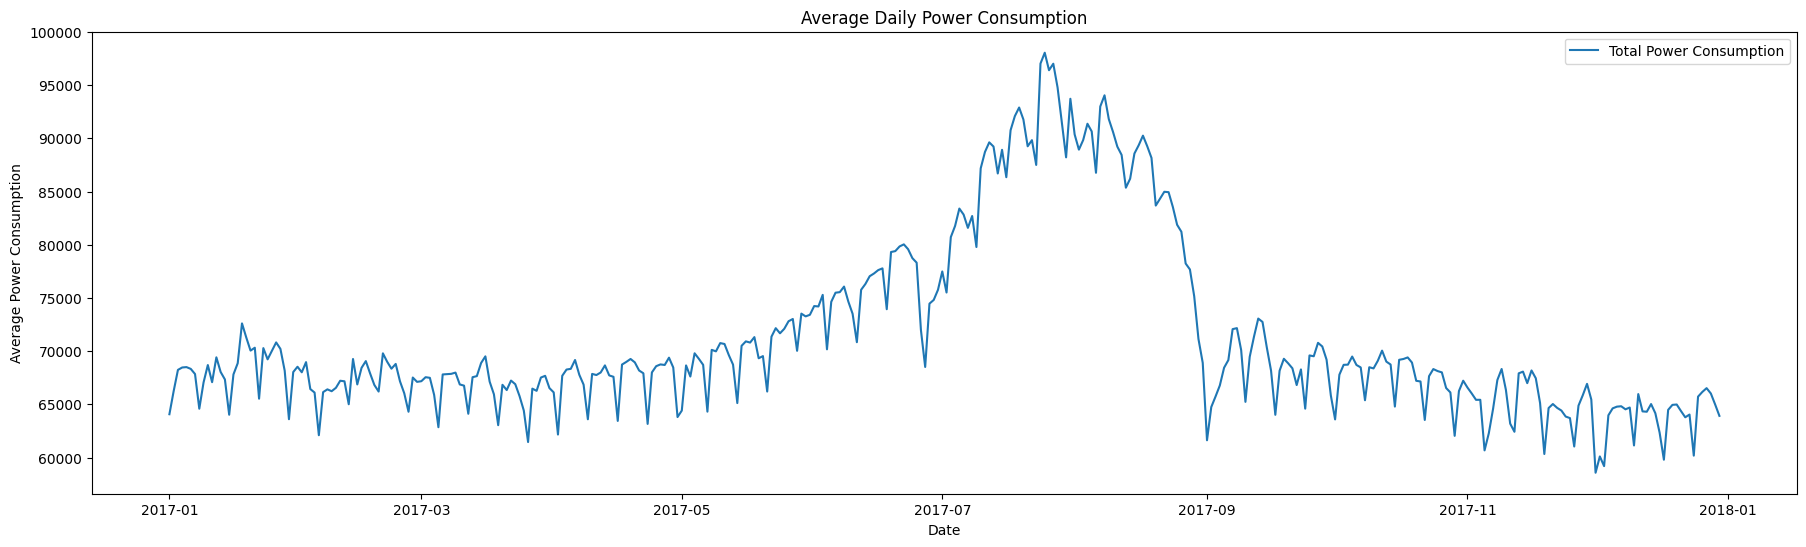

In [26]:
# Resample the 'TotalPowerConsumption' column to daily frequency and calculate the mean
daily_resampled = df['TotalPowerConsumption'].resample('D').mean()

# Plot daily Total Power Consumption
plt.figure(figsize=(22, 6))
sns.lineplot(data=daily_resampled)
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend(labels=['Total Power Consumption'])
plt.show()

### Per Capita Consumption


### Population in the city of Tetouan

The total population will be used to calculate per capita consumption, which is what we aim to predict in the models.



In [27]:
total_individuals = 399817
df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night
Datetime,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,70425.53544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,69320.84387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,67803.22193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,65489.23209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,63650.44627,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [28]:
df['PerCapitaConsumption'] = df['TotalPowerConsumption'] / total_individuals

### Average income per capita in Morocco by year

In [29]:
AverageIncome_2017= 3288.50
AverageIncome_2024= 3489
# source: https://ycharts.com/indicators/morocco_gdp_per_capita_usd

df.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,PerCapitaConsumption
Datetime,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,2017,1,1,0,1,1,70425.53544,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.176144
2017-01-01 00:10:00,6.414,74.5,0.083,2017,1,1,0,1,1,69320.84387,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.173381
2017-01-01 00:20:00,6.313,74.5,0.080,2017,1,1,0,1,1,67803.22193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.169586
2017-01-01 00:30:00,6.121,75.0,0.083,2017,1,1,0,1,1,65489.23209,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.163798
2017-01-01 00:40:00,5.921,75.7,0.081,2017,1,1,0,1,1,63650.44627,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.159199


In [30]:
# Calculate the monthly income
monthly_income_morocco_2017 = AverageIncome_2017 / 12
monthly_income_morocco_2024 = AverageIncome_2024 / 12
monthly_income_morocco_2017

274.0416666666667

# Lag Shifted

In [31]:
numeric_cols = df.select_dtypes(include=['float64', 'int64', 'int32'])

# Resample data to calculate mean values for selected columns
df_grouped = numeric_cols.resample('h').mean()  # Resample hourly and take mean

# Columns to create lag features using mean values
columns_to_lag = [
    'Temperature', 'Humidity', 'WindSpeed'
]

# Lag values (2, 4, 6, ..., 48 hours)
lags = [x for x in range(2,49,2)]

# Create lag features on the grouped (mean) data
df_lagged = df_grouped.copy()

for col in columns_to_lag:
    for lag in lags:
        df_lagged[f'{col}_lag{lag}'] = df_grouped[col].shift(lag)

# Remove rows with NaN values due to lagging
df_lagged = df_lagged.dropna()
df_lagged.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,TotalPowerConsumption,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,PerCapitaConsumption,Temperature_lag2,Temperature_lag4,Temperature_lag6,Temperature_lag8,Temperature_lag10,Temperature_lag12,Temperature_lag14,Temperature_lag16,Temperature_lag18,Temperature_lag20,Temperature_lag22,Temperature_lag24,Temperature_lag26,Temperature_lag28,Temperature_lag30,Temperature_lag32,Temperature_lag34,Temperature_lag36,Temperature_lag38,Temperature_lag40,Temperature_lag42,Temperature_lag44,Temperature_lag46,Temperature_lag48,Humidity_lag2,Humidity_lag4,Humidity_lag6,Humidity_lag8,Humidity_lag10,Humidity_lag12,Humidity_lag14,Humidity_lag16,Humidity_lag18,Humidity_lag20,Humidity_lag22,Humidity_lag24,Humidity_lag26,Humidity_lag28,Humidity_lag30,Humidity_lag32,Humidity_lag34,Humidity_lag36,Humidity_lag38,Humidity_lag40,Humidity_lag42,Humidity_lag44,Humidity_lag46,Humidity_lag48,WindSpeed_lag2,WindSpeed_lag4,WindSpeed_lag6,WindSpeed_lag8,WindSpeed_lag10,WindSpeed_lag12,WindSpeed_lag14,WindSpeed_lag16,WindSpeed_lag18,WindSpeed_lag20,WindSpeed_lag22,WindSpeed_lag24,WindSpeed_lag26,WindSpeed_lag28,WindSpeed_lag30,WindSpeed_lag32,WindSpeed_lag34,WindSpeed_lag36,WindSpeed_lag38,WindSpeed_lag40,WindSpeed_lag42,WindSpeed_lag44,WindSpeed_lag46,WindSpeed_lag48
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,11.840000,75.533333,0.074833,2017.0,1.0,3.0,0.0,0.0,0.0,59671.767438,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.149248,12.876667,13.411667,14.206667,15.238333,15.563333,15.168333,12.865000,8.873333,9.336667,10.253333,11.031667,10.666667,12.791667,11.690000,14.013333,15.471667,15.766667,14.846667,6.145333,4.655167,4.571667,5.097667,5.054333,6.196833,68.675000,68.645000,65.691667,60.763333,55.986667,58.125000,74.436667,83.916667,84.650000,81.933333,76.750000,78.033333,66.206667,70.883333,65.273333,58.291667,55.636667,57.078333,69.635000,73.600000,75.750000,74.050000,78.933333,75.066667,0.074667,0.075167,0.076000,0.076000,0.075667,0.076000,0.076667,0.081833,0.076000,0.076167,0.077833,0.076667,0.074333,0.077167,0.077333,0.076000,0.076500,0.075667,3.738500,0.082667,0.082167,0.082333,0.082333,0.081833
2017-01-03 01:00:00,12.131667,72.566667,0.076500,2017.0,1.0,3.0,1.0,0.0,0.0,53044.344748,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.132672,12.473333,13.125000,13.523333,14.966667,15.475000,15.306667,15.050000,9.488333,9.543333,9.730000,10.568333,10.703333,11.711667,11.748333,11.810000,15.146667,15.558333,15.680000,9.893333,4.609167,4.453833,4.741667,5.004333,5.548833,71.716667,66.961667,69.695000,61.641667,57.263333,59.308333,58.008333,86.116667,84.900000,83.550000,79.266667,78.916667,72.506667,70.826667,70.208333,59.933333,58.191667,57.071667,58.036667,73.983333,73.400000,75.233333,77.083333,77.583333,0.074833,0.075333,0.075500,0.077333,0.075500,0.076333,0.076167,0.079833,0.077333,0.077000,0.077500,0.076167,0.075000,0.075333,0.077500,0.078500,0.074833,0.076667,2.088167,0.082167,0.082667,0.081000,0.082833,0.082000
2017-01-03 02:00:00,11.788333,73.883333,0.076833,2017.0,1.0,3.0,2.0,0.0,0.0,49677.844478,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.124251,11.840000,12.876667,13.411667,14.206667,15.238333,15.563333,15.168333,12.865000,8.873333,9.336667,10.253333,11.031667,10.666667,12.791667,11.690000,14.013333,15.471667,15.766667,14.846667,6.145333,4.655167,4.571667,5.097667,5.054333,75.533333,68.675000,68.645000,65.691667,60.763333,55.986667,58.125000,74.436667,83.916667,84.650000,81.933333,76.750000,78.033333,66.206667,70.883333,65.273333,58.291667,55.636667,57.078333,69.635000,73.600000,75.750000,74.050000,78.933333,0.074833,0.074667,0.075167,0.076000,0.076000,0.075667,0.076000,0.076667,0.081833,0.076000,0.076167,0.077833,0.076667,0.074333,0.077167,0.077333,0.076000,0.076500,0.075667,3.738500,0.082667,0.082167,0.082333,0.082333
2017-01-03 03:00:00,12.206667,73.933333

In [32]:
df_grouped.dtypes

Temperature              float64
Humidity                 float64
WindSpeed                float64
Year                     float64
Month                    float64
Day                      float64
Hour                     float64
IsHoliday                float64
IsWeekend                float64
TotalPowerConsumption    float64
Season_Autumn            float64
Season_Spring            float64
Season_Summer            float64
Season_Winter            float64
TimeOfDay_Afternoon      float64
TimeOfDay_Evening        float64
TimeOfDay_Morning        float64
TimeOfDay_Night          float64
PerCapitaConsumption     float64
dtype: object

# Per Capita Consumption analysis

Calculates the maximum per capita energy consumption by month and season.

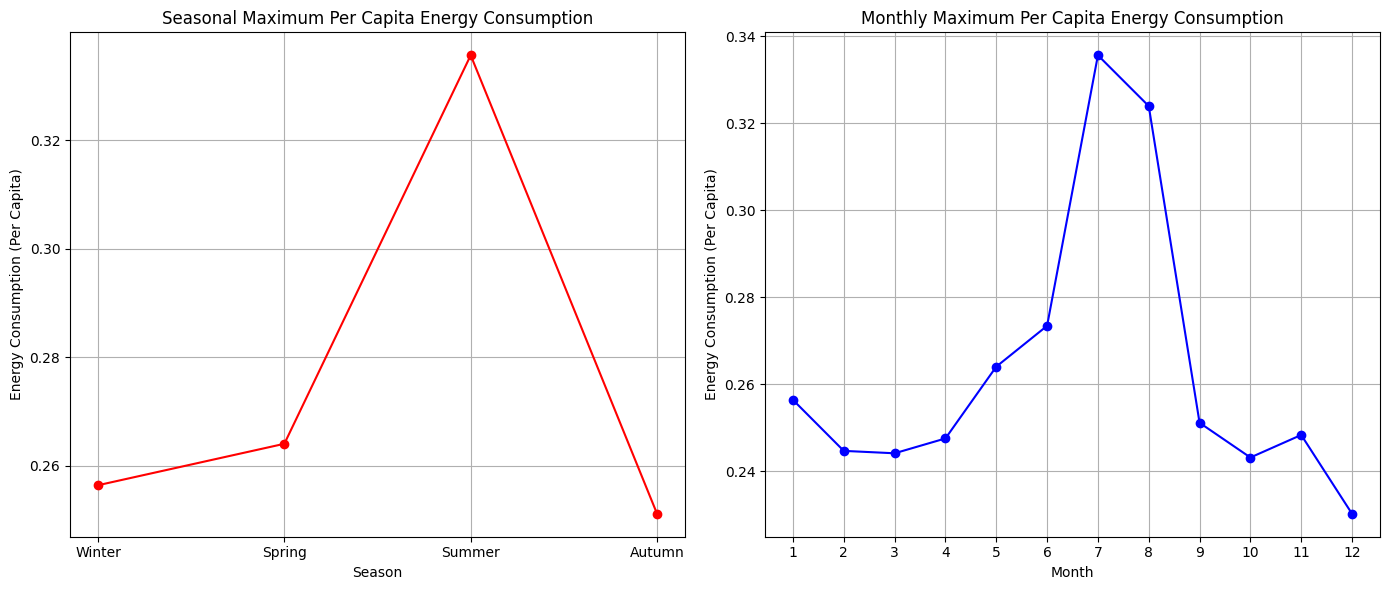

In [33]:
# Monthly maximum energy consumption for PerCapitaConsumption
monthly_max = df.groupby('Month')['PerCapitaConsumption'].max().reset_index()

# Create a 'Season' column based on the season one-hot encoded columns
# Ensure the seasonal columns are one-hot encoded (0 or 1) before summing
df['Season'] = df[['Season_Winter', 'Season_Spring', 'Season_Summer', 'Season_Autumn']].idxmax(axis=1).str.replace('Season_', '')

# Seasonal maximum energy consumption for PerCapitaConsumption
seasonal_max = df.groupby('Season')['PerCapitaConsumption'].max().reset_index()

# To display seasons in order
seasonal_max['Season'] = pd.Categorical(seasonal_max['Season'], categories=['Winter', 'Spring', 'Summer', 'Autumn'], ordered=True)
seasonal_max = seasonal_max.sort_values('Season')

# Create a subplot figure with 1 row and 2 columns
plt.figure(figsize=(14, 6))

# Plot for seasonal maximum energy consumption
plt.subplot(1, 2, 1)
plt.plot(seasonal_max['Season'], seasonal_max['PerCapitaConsumption'], marker='o', linestyle='-', color='r')
plt.title('Seasonal Maximum Per Capita Energy Consumption')
plt.xlabel('Season')
plt.ylabel('Energy Consumption (Per Capita)')
plt.grid(True)

# Plot for monthly maximum energy consumption
plt.subplot(1, 2, 2)
plt.plot(monthly_max['Month'], monthly_max['PerCapitaConsumption'], marker='o', linestyle='-', color='b')
plt.title('Monthly Maximum Per Capita Energy Consumption')
plt.xlabel('Month')
plt.ylabel('Energy Consumption (Per Capita)')
plt.grid(True)
plt.xticks(range(1, 13))

plt.tight_layout()
plt.show()

### Dropping encoded columns


In [34]:
df = df.drop(columns = ['Season'])
df = df.drop(columns = ['TotalPowerConsumption'])

# Scaling

The scaling is applied here to standardize the numerical values in the columns, bringing them between 0 and 1, to improve model performance and ensure that all variables have equal influence.

In [35]:
df_lagged = df_lagged.drop(columns = ['TotalPowerConsumption'])

In [36]:
# List of columns to scale
columns_to_scale = df_lagged.select_dtypes(include=['float64', 'int64']).columns
columns_to_scale= columns_to_scale.drop('PerCapitaConsumption')

# MinMaxScaler
scaler = MinMaxScaler()
df_lagged[columns_to_scale] = scaler.fit_transform(df_lagged[columns_to_scale])
pd.set_option('display.max_columns', None)
df_lagged.head()

,Temperature,Humidity,WindSpeed,Year,Month,Day,Hour,IsHoliday,IsWeekend,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning,TimeOfDay_Night,PerCapitaConsumption,Temperature_lag2,Temperature_lag4,Temperature_lag6,Temperature_lag8,Temperature_lag10,Temperature_lag12,Temperature_lag14,Temperature_lag16,Temperature_lag18,Temperature_lag20,Temperature_lag22,Temperature_lag24,Temperature_lag26,Temperature_lag28,Temperature_lag30,Temperature_lag32,Temperature_lag34,Temperature_lag36,Temperature_lag38,Temperature_lag40,Temperature_lag42,Temperature_lag44,Temperature_lag46,Temperature_lag48,Humidity_lag2,Humidity_lag4,Humidity_lag6,Humidity_lag8,Humidity_lag10,Humidity_lag12,Humidity_lag14,Humidity_lag16,Humidity_lag18,Humidity_lag20,Humidity_lag22,Humidity_lag24,Humidity_lag26,Humidity_lag28,Humidity_lag30,Humidity_lag32,Humidity_lag34,Humidity_lag36,Humidity_lag38,Humidity_lag40,Humidity_lag42,Humidity_lag44,Humidity_lag46,Humidity_lag48,WindSpeed_lag2,WindSpeed_lag4,WindSpeed_lag6,WindSpeed_lag8,WindSpeed_lag10,WindSpeed_lag12,WindSpeed_lag14,WindSpeed_lag16,WindSpeed_lag18,WindSpeed_lag20,WindSpeed_lag22,WindSpeed_lag24,WindSpeed_lag26,WindSpeed_lag28,WindSpeed_lag30,WindSpeed_lag32,WindSpeed_lag34,WindSpeed_lag36,WindSpeed_lag38,WindSpeed_lag40,WindSpeed_lag42,WindSpeed_lag44,WindSpeed_lag46,WindSpeed_lag48
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03 00:00:00,0.228240,0.765765,0.003430,0.0,0.0,0.066667,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.149248,0.256962,0.271785,0.293812,0.322395,0.331400,0.320456,0.256639,0.146045,0.158882,0.184279,0.205844,0.195731,0.254607,0.224084,0.288455,0.328860,0.337034,0.311544,0.070462,0.029175,0.026861,0.041435,0.040234,0.071889,0.682167,0.681802,0.645803,0.585731,0.527507,0.553571,0.752397,0.867951,0.876889,0.843775,0.780595,0.796238,0.652080,0.709085,0.640704,0.555603,0.523241,0.540813,0.693869,0.742199,0.768406,0.747684,0.807208,0.760076,0.003402,0.003487,0.003629,0.003629,0.003572,0.003629,0.003742,0.004621,0.003629,0.003657,0.003941,0.003742,0.003345,0.003827,0.003856,0.003629,0.003714,0.003572,0.626609,0.004763,0.004678,0.004706,0.004706,0.004621
2017-01-03 01:00:00,0.236321,0.729603,0.003714,0.0,0.0,0.066667,0.043478,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.132672,0.245787,0.263843,0.274879,0.314869,0.328953,0.324289,0.317177,0.163084,0.164608,0.169780,0.193007,0.196747,0.224684,0.225700,0.227409,0.319856,0.331262,0.334632,0.174305,0.027900,0.023597,0.031571,0.038849,0.053935,0.719243,0.661283,0.694600,0.596437,0.543068,0.567995,0.552149,0.894767,0.879937,0.863481,0.811271,0.807005,0.728872,0.708394,0.700857,0.575614,0.554384,0.540732,0.552495,0.746871,0.739761,0.762108,0.784658,0.790752,0.003430,0.003515,0.003544,0.003856,0.003544,0.003685,0.003657,0.004281,0.003856,0.003799,0.003884,0.003657,0.003459,0.003515,0.003884,0.004054,0.003430,0.003742,0.345892,0.004678,0.004763,0.004479,0.004791,0.004649
2017-01-03 02:00:00,0.226809,0.745653,0.003770,0.0,0.0,0.066667,0.086957,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.124251,0.228240,0.256962,0.271785,0.293812,0.322395,0.331400,0.320456,0.256639,0.146045,0.158882,0.184279,0.205844,0.195731,0.254607,0.224084,0.288455,0.328860,0.337034,0.311544,0.070462,0.029175,0.026861,0.041435,0.040234,0.765765,0.682167,0.681802,0.645803,0.585731,0.527507,0.553571,0.752397,0.867951,0.876889,0.843775,0.780595,0.796238,0.652080,0.709085,0.640704,0.555603,0.523241,0.540813,0.693869,0.742199,0.768406,0.747684,0.807208,0.003430,0.003402,0.003487,0.003629,0.003629,0.003572,0.003629,0.003742,0.004621,0.003629,0.003657,0.003941,0.003742,0.003345,0.003827,0.003856,0.003629,0.003714,0.003572,0.626609,0.004763,0.004678,0.004706,0.004706
2017-01-03 03:00:00,0.238399,0.746262,0.003657,0.0,0.0,0.066667,0.130435,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.119879,0.236321,0.245787,0.263843,0.274879,0.314869,0.328953,0.324289,0.317177,0.163084,0.1

# Models

## Time Series

### ARIMA

ARIMA was applied to capture time-based patterns in Per Capita Consumption, as it’s a common choice for univariate time series forecasting. However, the model produced a constant prediction line, showing its limitation when only time is considered. This result suggests that additional influential factors must be included for more accurate forecasting.

Checking stationarity of Per Capita Consumption series with ADF test for ARIMA readiness.

In [38]:
series = df['PerCapitaConsumption']

result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -26.567629573251537
p-value: 0.0


In [38]:
split_ratio = 0.7
split_index = int(len(series) * split_ratio)
train, test = series[:split_index], series[split_index:]

In [39]:
ARIMA_model = ARIMA(train, order=(1,1,5))
ARIMA_model_fit = ARIMA_model.fit()

print(ARIMA_model_fit.summary())

/.pyenv/versions/3.10.6/envs/Renewable_Energy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/.pyenv/versions/3.10.6/envs/Renewable_Energy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/.pyenv/versions/3.10.6/envs/Renewable_Energy/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


                                SARIMAX Results                                 
Dep. Variable:     PerCapitaConsumption   No. Observations:                36691
Model:                   ARIMA(1, 1, 5)   Log Likelihood              177528.736
Date:                  Wed, 06 Nov 2024   AIC                        -355043.472
Time:                          17:09:25   BIC                        -354983.900
Sample:                      01-01-2017   HQIC                       -355024.539
                           - 09-12-2017                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8538      0.007    115.224      0.000       0.839       0.868
ma.L1         -0.0113      0.007     -1.519      0.129      -0.026       0.003
ma.L2         -0.0404      0.007    

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-407202.629, Time=28.75 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-358049.567, Time=4.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-407167.631, Time=3.93 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-379508.861, Time=20.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-358051.564, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-407195.038, Time=11.62 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-407186.652, Time=39.85 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-405602.623, Time=36.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-407202.643, Time=43.93 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-407197.615, Time=17.71 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-407192.905, Time=33.25 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-407199.302, Time=52.31 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-407204.203, Time=29.80 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-400473.

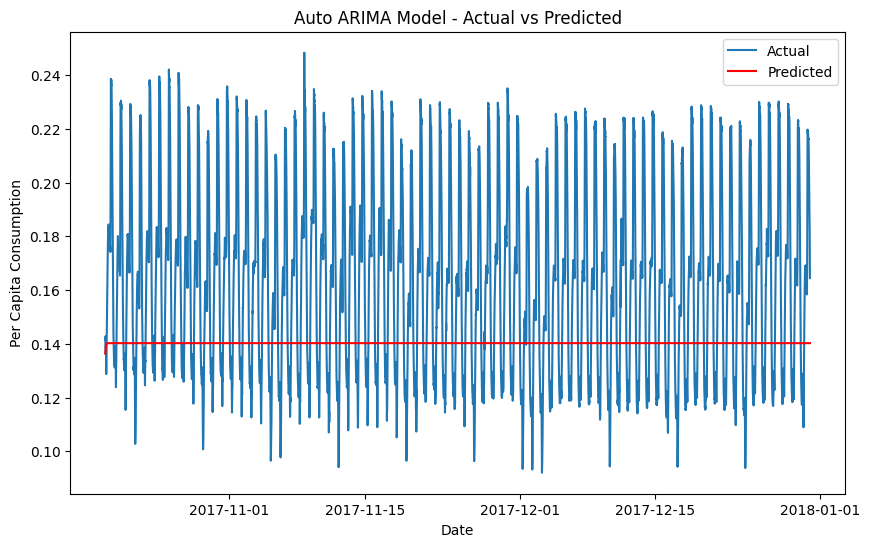

Mean Squared Error (MSE): 0.0017286149624331868
Mean Absolute Error (MAE): 0.03291315987375867


In [ ]:
split_ratio = 0.8
split_index = int(len(series) * split_ratio)
train, test = series[:split_index], series[split_index:]

# Automatically determine the best ARIMA parameters
ARIMA_auto_model = auto_arima(train, seasonal=False, trace=True)

ARIMA_auto_model.fit(train)

forecast = ARIMA_auto_model.predict(n_periods=len(test))

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('Auto ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Per Capita Consumption')
plt.legend()
plt.show()

# Calculate MSE and MAE for evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')


### SARIMA

In [39]:
split_ratio = 0.8
split_index = int(len(series) * split_ratio)
train, test = series[:split_index], series[split_index:]


In [ ]:
smodel = pm.auto_arima(train, seasonal=True, m=12,
                       start_p=0, max_p=2, max_d=2, start_q=0, max_q=2,
                       start_P=0, max_P=3, max_D=1, start_Q=0, max_Q=3,
                       trace=True, error_action='ignore', suppress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-358049.567, Time=6.99 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-406483.276, Time=25.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-380456.819, Time=28.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-358051.564, Time=1.24 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-407167.631, Time=6.11 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=-406568.142, Time=18.88 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-406553.292, Time=49.94 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=-407180.985, Time=8.87 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=-406502.486, Time=23.83 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=-406587.699, Time=28.88 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-406572.525, Time=47.59 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-407186.659, Time=36.60 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-406433.967, Time=76.08 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   :

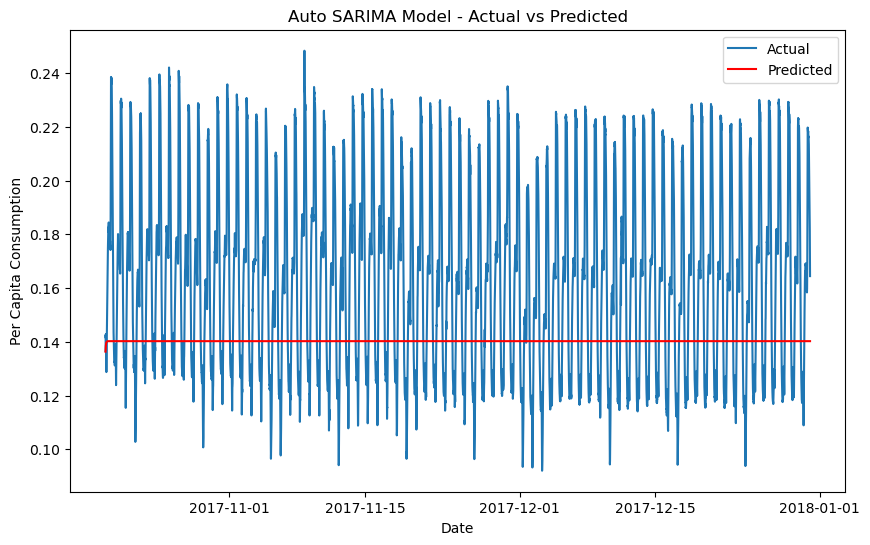

Mean Squared Error (MSE): 0.0017286149623424588
Mean Absolute Error (MAE): 0.032913159873115855


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Predicted', color='red')
plt.title('Auto SARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Per Capita Consumption')
plt.legend()
plt.show()

# Calculate MSE and MAE for evaluation
mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

## Linear Regression

The model performs well in minimizing errors, but with an **R² of 0.454**, there's still room for improvement in explaining more variance in the data.

In [37]:
X = df_lagged.drop(columns=['PerCapitaConsumption'])
y = df_lagged['PerCapitaConsumption']


In [38]:
train_size = 0.7
index = round(train_size * df_lagged.shape[0])

# Splitting for Time series
X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

print(f"Training data shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test data shape: X_test={X_test.shape}, y_test={y_test.shape}")


Training data shape: X_train=(6082, 89), y_train=(6082,)
Test data shape: X_test=(2606, 89), y_test=(2606,)


In [39]:
model1 = LinearRegression()

model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)


In [40]:
# Calculate the root mean square error (RMSE) and R²
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')

Root Mean Squared Error (RMSE): 0.02549903361548243
Mean Squared Error (MSE): 0.000650200715323503
Mean Absolute Error (MAE): 0.018801975103856162
R-squared (R²): 0.4544148997453271


The plot shows that while the predicted values follow the trend of the true values for both the training and test sets, there is noticeable scatter, especially in the test set. 

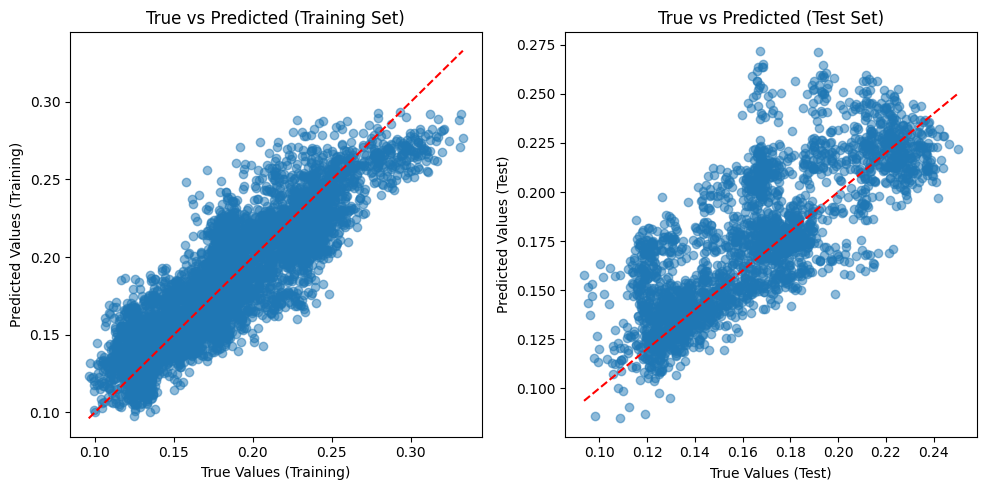

In [41]:
# Predict using the training set
y_train_pred = model1.predict(X_train)

# Plot the true vs predicted values for training set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel('True Values (Training)')
plt.ylabel('Predicted Values (Training)')
plt.title('True vs Predicted (Training Set)')

# Plot the true vs predicted values for test set
y_test_pred = model1.predict(X_test)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values (Test)')
plt.ylabel('Predicted Values (Test)')
plt.title('True vs Predicted (Test Set)')

plt.tight_layout()
plt.show()

## Train RandomForest Models


The results appears reasonable and highly suitable given the available metrics. The high values of R² indicate that the model explains the variation in energy consumption for each zone effectively, while the low values of MSE and MAE suggest that the actual errors are minimal.

Based on these metrics, it seems that the model is accurate and logical concerning your objective of predicting energy consumption for each zone. If these features have been used and the validity of the values is confirmed, this suggests that the model is performing efficiently and is well-suited for analyzing energy consumption.

In [36]:
X = df_lagged.drop(['PerCapitaConsumption'], axis=1, errors='ignore')
y = df_lagged['PerCapitaConsumption']


In [37]:
train_size = 0.7
index = round(train_size * df_lagged.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]


In [38]:
RFmodel1 = RandomForestRegressor(random_state=0)

RFmodel1.fit(X_train, y_train)
y_pred = RFmodel1.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R^2):", r2)

Mean Squared Error (MSE): 0.0002632276509313388
Mean Absolute Error (MAE): 0.013388716201560508
R-squared (R^2): 0.7791249979604793


Plotting learning curves using the R² metric to evaluate the performance of the Random Forest Regressor model.

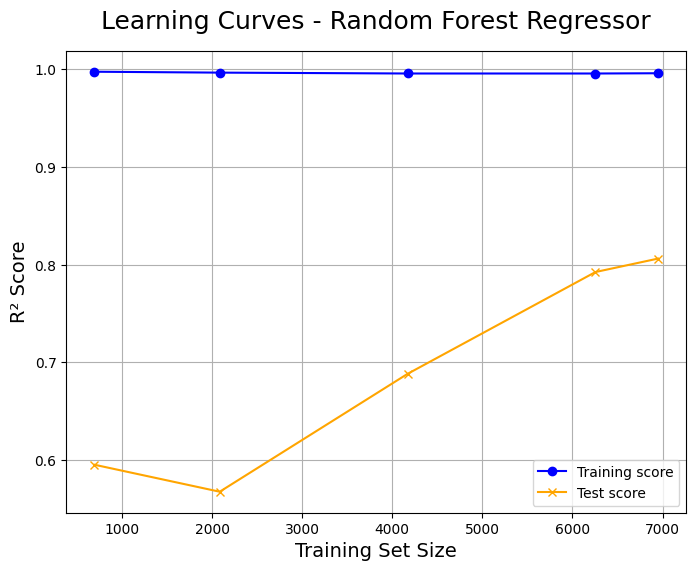

In [40]:
train_sizes = [0.1, 0.3, 0.6, 0.9, 1]

# Generate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    estimator=RFmodel1, X=X, y=y, train_sizes=train_sizes, cv=5, scoring='r2'
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Training score', marker='o', color='blue')
plt.plot(train_sizes, test_scores_mean, label='Test score', marker='x', color='orange')
plt.ylabel('R² Score', fontsize=14)
plt.xlabel('Training Set Size', fontsize=14)
plt.title('Learning Curves - Random Forest Regressor', fontsize=18, y=1.03)
plt.legend(loc='best')
plt.grid(True)
plt.show()

<!-- نشيك عليه -->

## Train lightgbm Models

The model trained using LightGBM performed well, achieving a **Mean Squared Error (MSE)** of 0.0051, a **Mean Absolute Error (MAE)** of 0.0597, and an **R-squared (R²)** of 75.43%. This indicates that the model can make accurate predictions, though with slightly lower precision compared to the previous model.

In [48]:
model1 = lgb.LGBMRegressor(random_state=0)

model1.fit(X_train, y_train)

y1_pred = model1.predict(X_test)

print("Mean Squared Error (MSE):",  np.mean((y1_pred - y_test)**2))
print("Mean Absolute Error (MAE):",  mean_absolute_error(y_test, y1_pred))
print("R-squared (R²):", r2_score(y_test, y1_pred))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19209
[LightGBM] [Info] Number of data points in the train set: 6082, number of used features: 88
[LightGBM] [Info] Start training from score 0.183790
Mean Squared Error (MSE): 0.00028109213741914587
Mean Absolute Error (MAE): 0.014040266626088673
R-squared (R²): 0.7641348611892531


The plot shows that the training error is low and stable, while the validation error decreases as the training set size increases, indicating improved model performance with more data and no overfitting issues.

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10792
[LightGBM] [Info] Number of data points in the train set: 486, number of used features: 85
[LightGBM] [Info] Start training from score 0.167820
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18312
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 85
[LightGBM] [Info] Start training from score 0.

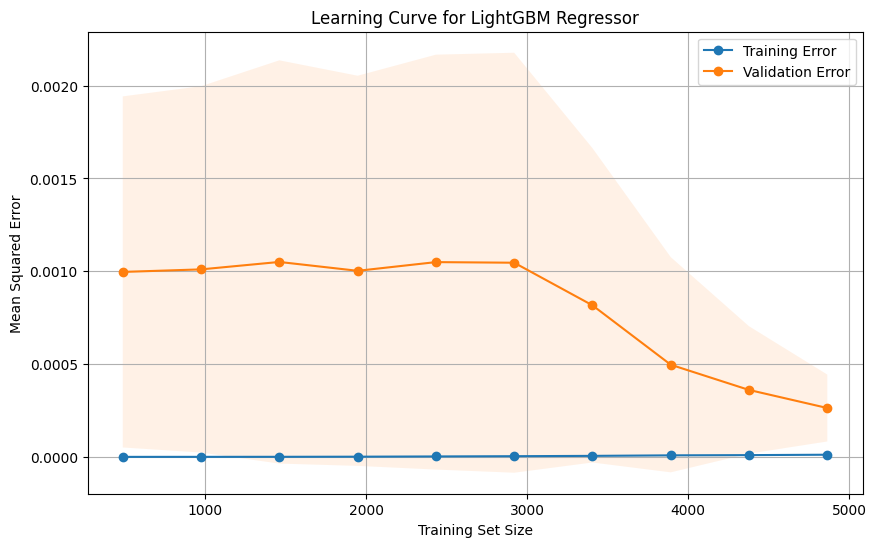

In [ ]:
model1 = lgb.LGBMRegressor(random_state=0)

# Generate the learning curve data
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=model1,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training Error', marker='o')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
plt.plot(train_sizes, validation_scores_mean, label='Validation Error', marker='o')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1)

plt.title('Learning Curve for LightGBM Regressor')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Train XGBoost Models

The XGBoost model achieved the best results, with a low MAE of 0.0115 and an R² of 81.73%, indicating high predictive accuracy with minimal errors.


In [ ]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500, 700],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

# Create the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

# Create GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Use the best parameters to train the final model
best_params = grid_search.best_params_
xgb_model_optimized = xgb.XGBRegressor(**best_params)
xgb_model_optimized.fit(X_train, y_train)

# Make predictions
y_pred_optimized = xgb_model_optimized.predict(X_test)

# Evaluate
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
r2_optimized = r2_score(y_test, y_pred_optimized)
print(f"Optimized Mean Squared Error (MSE): {mse_optimized:.4f}")
print(f"Optimized R-squared (R²): {r2_optimized:.4f}")


Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Optimized Mean Squared Error (MSE): 0.0036
Optimized R-squared (R²): 0.8273


Prepare the Data

In [ ]:
# Define features (X) and target variable (y) from the dataset
X = df_lagged.drop(columns=['PerCapitaConsumption'])
y = df_lagged['PerCapitaConsumption']

# Split the data into training and testing sets based on time series order
train_size = 0.7
index = round(train_size * df_lagged.shape[0])
X_train = X.iloc[:index]
X_test = X.iloc[index:]
y_train = y.iloc[:index]
y_test = y.iloc[index:]

Train the Model

In [ ]:
# Convert the training and testing data into DMatrix, which is required by XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set up the parameters for the XGBoost model
params = {
    'max_depth': 2,
    'learning_rate': 0.01,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}
# Create a dictionary to store evaluation results and train the XGBoost model
evals_result = {}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=False
)

# Make predictions on the test set
y_pred = xgb_model.predict(dtest)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.0115
Mean Squared Error (MSE): 0.0002
R-squared (R²): 0.8173


Visualize Training and Validation Performance

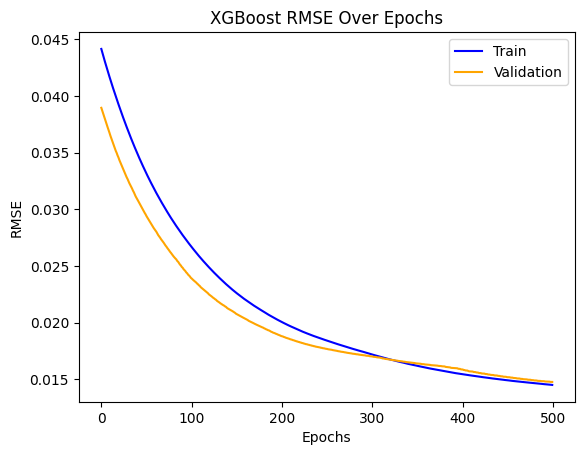

In [ ]:
epochs = len(evals_result['train']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, evals_result['train']['rmse'], label='Train', color='blue')
ax.plot(x_axis, evals_result['eval']['rmse'], label='Validation', color='orange')

ax.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('XGBoost RMSE Over Epochs')

plt.show()

Saving the Model: Exporting the XGBoost Pipeline as a Pickle File

In [ ]:
import pickle

# Export Pipeline as pickle file
with open("model2.pkl", "wb") as file:
    pickle.dump(xgb_model, file)

## RNN: LSTM

The LSTM model shows good performance with a low MAE of 0.0132, explaining 70.5% of the variance (R² = 0.7051). The performance is stable on both the training and validation sets, but there is slight room for improvement.

In [50]:
X = df.drop([['PerCapitaConsumption']], axis=1, errors='ignore')
y = df['PerCapitaConsumption']

In [51]:
train_size = 0.7
index = round(train_size * df.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [52]:
normalizer = Normalization()
normalizer.adapt(X_train)

model_LSTM = Sequential()
model_LSTM.add(normalizer)
model_LSTM.add(LSTM(units=20, activation='tanh'))
model_LSTM.add(Dense(10, activation='relu'))
model_LSTM.add(Dense(1, activation='linear'))

model_LSTM.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [53]:
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_LSTM = model_LSTM.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, verbose=2, callbacks=[es])
y_pred = model_LSTM.predict(X_test)

Epoch 1/100
918/918 - 5s - 6ms/step - loss: 0.0016 - mae: 0.0181 - val_loss: 0.0087 - val_mae: 0.0520
Epoch 2/100
918/918 - 2s - 2ms/step - loss: 3.5196e-05 - mae: 0.0044 - val_loss: 0.0093 - val_mae: 0.0512
Epoch 3/100
918/918 - 2s - 2ms/step - loss: 1.4252e-05 - mae: 0.0029 - val_loss: 0.0101 - val_mae: 0.0518
Epoch 4/100
918/918 - 3s - 3ms/step - loss: 7.9606e-06 - mae: 0.0021 - val_loss: 0.0107 - val_mae: 0.0525
Epoch 5/100
918/918 - 2s - 2ms/step - loss: 4.9555e-06 - mae: 0.0017 - val_loss: 0.0112 - val_mae: 0.0531
Epoch 6/100
918/918 - 2s - 2ms/step - loss: 3.3914e-06 - mae: 0.0014 - val_loss: 0.0115 - val_mae: 0.0540
Epoch 7/100
918/918 - 2s - 2ms/step - loss: 2.5097e-06 - mae: 0.0012 - val_loss: 0.0117 - val_mae: 0.0536
Epoch 8/100
918/918 - 2s - 2ms/step - loss: 2.0193e-06 - mae: 0.0011 - val_loss: 0.0119 - val_mae: 0.0538
Epoch 9/100
918/918 - 2s - 2ms/step - loss: 1.7253e-06 - mae: 9.8586e-04 - val_loss: 0.0119 - val_mae: 0.0535
Epoch 10/100
918/918 - 2s - 2ms/step - loss: 1

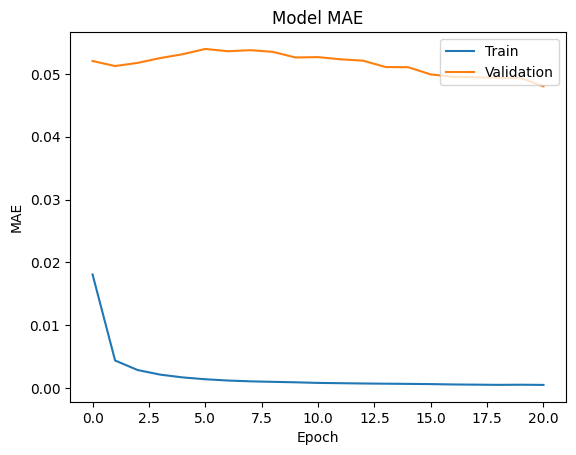

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0419 - mae: 0.1964
Model Mean Absolute Error (LSTM): 0.1530
R^2: -24.6977
Mean Squared Error (MSE): 0.0313


In [54]:
plt.plot(history_LSTM.history['mae'])
plt.plot(history_LSTM.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model on the test set
lstm_mae = model_LSTM.evaluate(X_test, y_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Model Mean Absolute Error (LSTM): {lstm_mae[1]:.4f}')
print(f"R^2: {r2:.4f}")
print(f'Mean Squared Error (MSE): {mse:.4f}')

## RNN: GRU

The GRU model shows a significant drop in MAE for both training and validation data, indicating good initial learning. However, the extremely negative R² value (-907.5975) suggests a major issue with the model's ability to generalize, indicating poor performance in predicting validation data, which may require adjustments to the model or input data.

In [42]:
X = df.drop(['PerCapitaConsumption'], axis=1, errors='ignore').resample('D').mean()
y = df['PerCapitaConsumption'].resample('D').mean()

In [43]:
train_size = 0.7
index = round(train_size * len(X))

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

# Reshape the data to 3D for GRU
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [44]:
normalizer = Normalization()
normalizer.adapt(X_train)

model_GRU = Sequential()
model_GRU.add(normalizer)
model_GRU.add(GRU(units=20, activation='tanh', return_sequences=False))
model_GRU.add(Dense(10, activation='relu'))
model_GRU.add(Dense(1, activation='linear'))

model_GRU.compile(loss='mse', optimizer='adam', metrics=['mae'])

In [46]:
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history_GRU = model_GRU.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=100, verbose=2, callbacks=[es])

y_pred = model_GRU.predict(X_test)

Epoch 1/100
7/7 - 4s - 560ms/step - loss: 0.0237 - mae: 0.1154 - val_loss: 0.0287 - val_mae: 0.1324
Epoch 2/100
7/7 - 1s - 82ms/step - loss: 0.0113 - mae: 0.0712 - val_loss: 0.0201 - val_mae: 0.0945
Epoch 3/100
7/7 - 0s - 14ms/step - loss: 0.0068 - mae: 0.0547 - val_loss: 0.0151 - val_mae: 0.0789
Epoch 4/100
7/7 - 0s - 19ms/step - loss: 0.0048 - mae: 0.0469 - val_loss: 0.0102 - val_mae: 0.0695
Epoch 5/100
7/7 - 0s - 14ms/step - loss: 0.0029 - mae: 0.0373 - val_loss: 0.0070 - val_mae: 0.0589
Epoch 6/100
7/7 - 0s - 19ms/step - loss: 0.0019 - mae: 0.0298 - val_loss: 0.0048 - val_mae: 0.0496
Epoch 7/100
7/7 - 0s - 11ms/step - loss: 0.0014 - mae: 0.0256 - val_loss: 0.0039 - val_mae: 0.0461
Epoch 8/100
7/7 - 0s - 13ms/step - loss: 0.0011 - mae: 0.0230 - val_loss: 0.0036 - val_mae: 0.0443
Epoch 9/100
7/7 - 0s - 12ms/step - loss: 8.2114e-04 - mae: 0.0205 - val_loss: 0.0036 - val_mae: 0.0442
Epoch 10/100
7/7 - 0s - 10ms/step - loss: 6.7754e-04 - mae: 0.0186 - val_loss: 0.0037 - val_mae: 0.0445


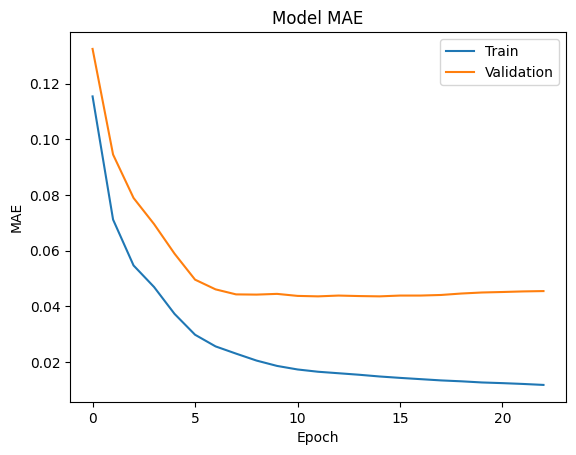

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - mae: 0.0972
Model Mean Absolute Error (GRU): 0.1055
R^2: -300.0375


In [47]:
plt.plot(history_GRU.history['mae'])
plt.plot(history_GRU.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Evaluate the model on the test set
gru_mae = model_GRU.evaluate(X_test, y_test)
r2 = r2_score(y_test, y_pred)

print(f'Model Mean Absolute Error (GRU): {gru_mae[1]:.4f}')
print(f"R^2: {r2:.4f}")

## Multilayer Perceptron model (MLP)

The second model shows that the **training error** started very high but quickly dropped within the first epoch. Meanwhile, the **validation error** remained consistently low throughout the training, indicating that the model performs well after adjusting the learning rate.

In [66]:
X = df_lagged.drop(['PerCapitaConsumption'], axis=1, errors='ignore')
y = df_lagged['PerCapitaConsumption']

In [67]:
train_size = 0.6
index = round(train_size * df_lagged.shape[0])

X_train = X.iloc[:index]
X_test = X.iloc[index:]

y_train = y.iloc[:index]
y_test = y.iloc[index:]

epochs = 500
batch = 256
lr = 0.1

adam = Adam(learning_rate=lr)

In [68]:
model_mlp2 = Sequential()

# Layer with an increased number of neurons
model_mlp2.add(Dense(200, activation='relu', input_dim=X_train.shape[1]))

# Dropout To reduce overfitting
model_mlp2.add(Dropout(0.3))

# L2 regularization
model_mlp2.add(Dense(100, activation='relu', kernel_regularizer=l2(0.001)))
model_mlp2.add(Dense(50, activation='relu'))

model_mlp2.add(Dense(1))
model_mlp2.compile(loss='mse', optimizer=adam)
model_mlp2.summary()

/.pyenv/versions/3.10.6/envs/Renewable_Energy/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 200)            │        18,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,201 (168.75 KB)

 Trainable params: 43,201 (168.75 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Add EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


mlp_history2 = model_mlp2.fit(X_train.values, y_train, validation_data=(X_test.values, y_test), epochs=epochs, batch_size=batch, verbose=2, callbacks=[early_stopping])

Epoch 1/500


21/21 - 2s - 83ms/step - loss: 43809.5703 - val_loss: 2.1066
Epoch 2/500
21/21 - 0s - 7ms/step - loss: 1.6743 - val_loss: 1.5047
Epoch 3/500
21/21 - 0s - 6ms/step - loss: 1.5434 - val_loss: 1.5152
Epoch 4/500
21/21 - 0s - 7ms/step - loss: 1.4998 - val_loss: 1.4700
Epoch 5/500
21/21 - 0s - 6ms/step - loss: 1.4690 - val_loss: 1.4546
Epoch 6/500
21/21 - 0s - 6ms/step - loss: 1.4495 - val_loss: 1.4409
Epoch 7/500
21/21 - 0s - 6ms/step - loss: 1.4348 - val_loss: 1.4300
Epoch 8/500
21/21 - 0s - 6ms/step - loss: 1.4257 - val_loss: 1.4166
Epoch 9/500
21/21 - 0s - 6ms/step - loss: 1.4147 - val_loss: 1.4097
Epoch 10/500
21/21 - 0s - 6ms/step - loss: 1.4071 - val_loss: 1.4016
Epoch 11/500
21/21 - 0s - 7ms/step - loss: 1.3993 - val_loss: 1.3943
Epoch 12/500
21/21 - 0s - 6ms/step - loss: 1.3926 - val_loss: 1.3887
Epoch 13/500
21/21 - 0s - 6ms/step - loss: 1.3866 - val_loss: 1.3827
Epoch 14/500
21/21 - 0s - 6ms/step - loss: 1.3813 - val_loss: 1.3782
Epoch 15/500
21/21 - 0s - 6ms/step - loss: 1.3773 

In [70]:
# Prediction
train_predict2 = model_mlp2.predict(X_train)
test_predict2 = model_mlp2.predict(X_test)

163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [71]:
# Calculate MSE, MAE
mse2 = mean_squared_error(y_test, test_predict2)
mae2 = mean_absolute_error(y_test, test_predict2)

print("Mean squared error on test set: {:.4f}".format(mse))
print("Mean absolute error on test set: {:.4f}".format(mae))

Mean squared error on test set: 0.0313
Mean absolute error on test set: 0.0134


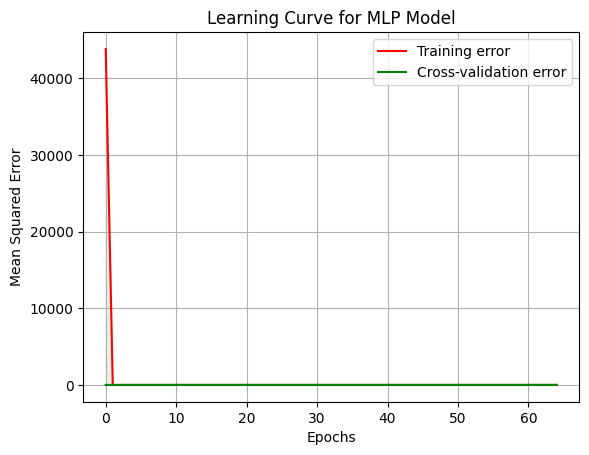

In [72]:
train_loss = mlp_history2.history['loss']
val_loss = mlp_history2.history['val_loss']

plt.plot(train_loss, 'r-', label='Training error')
plt.plot(val_loss, 'g-', label='Cross-validation error')

plt.fill_between(np.arange(len(train_loss)), train_loss, val_loss, color='green', alpha=0.1)

plt.title('Learning Curve for MLP Model')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend(loc='upper right')
plt.grid(True)

plt.show()

-----
-----
-----
